In [96]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [97]:
train = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\train.csv')
test = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\test.csv')
submit = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\head_submit_sample.csv')

In [98]:
test

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure
18046,18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown
18047,18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown
18048,18048,31,technician,single,secondary,no,65483,yes,no,unknown,15,may,345,2,41,0,unknown


In [99]:
len(test['id'].values)

18050

In [73]:
#score列の作成
train['score'] = np.zeros(train.shape[0])


#個人ローン
#学習データ
loan_none = train.loc[train['loan'] == 'no']
index = loan_none.index.values
index = list(index)

for i in index:
    train.iloc[i,18] = 1
    


#住宅ローン
housing_none = train.loc[train['housing'] == 'no']
index = housing_none.index.values
index = list(index)

score_values = housing_none['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['housing']=='no','score'] = i



#債務不履行
default = train.loc[train['default'] == 'yes']


score_values = default['score'].values
score_values = score_values - 3
score_values = list(score_values)

for i in score_values:
    train.loc[train['default']=='yes','score'] = i





#経営者
management = train.loc[train['job'] == 'management']


score_values = management['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='management','score'] = i
    


#管理者
admin = train.loc[train['job'] == 'admin.']


score_values = admin['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='admin.','score'] = i
    



#学生
student = train.loc[train['job'] == 'student']


score_values = student['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='student','score'] = i
    




#失業者
unemployed = train.loc[train['job'] == 'unemployed']


score_values = unemployed['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='unemployed','score'] = i
    
train.loc[train['job'] == 'unemployed']




#定年退職者
retired = train.loc[train['job'] == 'retired']


score_values = retired['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    train.loc[train['job']=='retired','score'] = i

In [74]:
#テストデータ
#score列の作成
test['score'] = np.zeros(test.shape[0])

#個人ローン
loan_none = test.loc[test['loan'] == 'no']
index = loan_none.index.values
index = list(index)

for i in index:
    test.iloc[i,17] = 1



#住宅ローン
housing_none = test.loc[test['housing'] == 'no']

score_values = housing_none['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['housing']=='no','score'] = i



#債務不履行
default = test.loc[test['default'] == 'yes']


score_values = default['score'].values
score_values = score_values - 3
score_values = list(score_values)

for i in score_values:
    test.loc[test['default']=='yes','score'] = i





#経営者
management = test.loc[test['job'] == 'management']


score_values = management['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='management','score'] = i
    


#管理者
admin = test.loc[test['job'] == 'admin.']


score_values = admin['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='admin.','score'] = i
    



#学生
student = test.loc[test['job'] == 'student']


score_values = student['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='student','score'] = i
    




#失業者
unemployed = test.loc[test['job'] == 'unemployed']


score_values = unemployed['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='unemployed','score'] = i
    



#定年退職者
retired = test.loc[test['job'] == 'retired']


score_values = retired['score'].values
score_values = score_values + 1
score_values = list(score_values)

for i in score_values:
    test.loc[test['job']=='retired','score'] = i

In [75]:
#totalカラムの追加
before = train.previous.values
carent = train.campaign.values
total = before + carent
train['total'] = total

before = test.previous.values
carent = test.campaign.values
total = before + carent
test['total'] = total

# 元データにone-hotエンコーディングが一番結果が良い

In [100]:
#jobの欠損値処理
test.replace({'job': {'unknown':'blue-collar'}}, inplace=True)

#各データセットの作成
train_x = train.iloc[:,1:17]
#train_x['score'] = train['score']
#train_x['total'] = train['total']
train_y = train['y']
test_x = test.iloc[:,1:]


cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']

#one-hot-encoding
all_x = pd.concat([train_x,test_x])
all_x = pd.get_dummies(all_x, columns=cat_cols)

train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)



#TargetEncording
#TargetEncording用のfoldに分割してTargetEncordingする方法    
#for c in cat_cols:
    #学習データのカテゴリカル変数のカラムごとの変数とtargetをデータフレームとする。
    #data_tmp = pd.DataFrame({c:train_x[c], 'target': train_y})
    #データフレームのカラムの要素ごとの平均を取る
    #target_mean = data_tmp.groupby(c)['target'].mean()
    #訓練データフレームの平均をテストデータに入れる。
    #test_x.loc[:,c] = test_x[c].map(target_mean)
    
    #訓練データを入れるための空の箱を作る
    #tmp = np.repeat(np.nan, train_x.shape[0])
    
    
    #one of out holdで一つ一つのバリデーションに平均値を入れていく
    #kf =  KFold(n_splits=4, shuffle=True, random_state=71)
    #for idx_1, idx_2 in kf.split(train_x):
        
        #target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
        
        #tmp[idx_2] = train_x[c].iloc[idx_2].map(target_mean)
        
    #train_x[c] = tmp
    
    
#hold out 法
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]

tr_x,va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y,va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]  


scaler = StandardScaler()
tr_x = scaler.fit_transform(tr_x)
va_x = scaler.fit_transform(va_x)
test_x = scaler.fit_transform(test_x)

In [101]:
model = Sequential()
model.add(Dense(256,activation='relu',input_shape=(train_x.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer ='adam', metrics=['accuracy'])

batch_size = 128
epochs = 100
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)


history  = model.fit(tr_x,tr_y,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1,validation_data=(va_x,va_y),
                    callbacks = early_stopping)

va_pred = model.predict(va_x)
score = log_loss(va_y,va_pred, eps=1e-7)
print(score)

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2445 - accuracy: 0.9218 - val_loss: 0.2078 - val_accuracy: 0.9330
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2142 - accuracy: 0.9299 - val_loss: 0.2092 - val_accuracy: 0.9323
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.2094 - accuracy: 0.9293 - val_loss: 0.2057 - val_accuracy: 0.9340
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.2065 - accuracy: 0.9308 - val_loss: 0.2051 - val_accuracy: 0.9345
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.2050 - accuracy: 0.9316 - val_loss: 0.2050 - val_accuracy: 0.9343
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.2034 - accuracy: 0.9320 - val_loss: 0.2049 - val_accuracy: 0.9331
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.2010 - accuracy: 0.9323 - val_loss: 0.2060 - val_accuracy: 0.9337

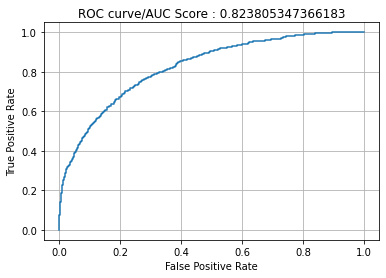

In [102]:
fig = plt.figure()

fpr,tpr,thresholds = roc_curve(va_y,va_pred)
auc_score = roc_auc_score(va_y,va_pred)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve/AUC Score : {auc_score}')

plt.grid(True)

In [103]:
test_pred = model.predict(test_x)
test_pred.shape

(18050, 1)

In [105]:
current = test['id']
current = pd.DataFrame(current)
current['y'] = test_pred
current

,id,y
0,0,0.820805
1,1,0.045376
2,2,0.069645
3,3,0.024525
4,4,0.052607
...,...,...
18045,18045,0.008802
18046,18046,0.015860
18047,18047,0.119094
18048,18048,0.030983


In [106]:
current.to_csv('NN_for_keras.csv')